The output in looker studio:
[LINK](https://lookerstudio.google.com/embed/reporting/2d94a92e-7881-4adf-bfd7-c32a2c5b77fb/page/axcID)

BiClustering with KMeans

In [2]:
import pandas as pd
import chardet
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralBiclustering

Silhouette score for 2 clusters: 0.355577924666922
Silhouette score for 3 clusters: 0.2840791369939187
Silhouette score for 4 clusters: 0.28975712052571395
Silhouette score for 5 clusters: 0.30348781444772255
Silhouette score for 6 clusters: 0.3191120282607703
Silhouette score for 7 clusters: 0.3142378726012875
Silhouette score for 8 clusters: 0.3009156134365435
Silhouette score for 9 clusters: 0.29194169288377225
Silhouette score for 10 clusters: 0.33851705989162917


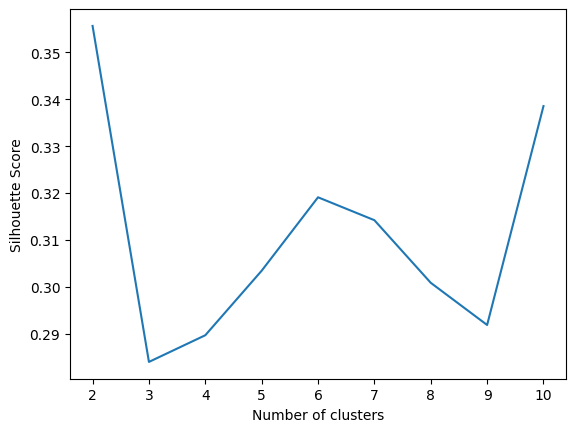

In [5]:
# Detect the file encoding
with open('testHeatRawData1.csv', 'rb') as file:
    raw_data = file.read()
    encoding = chardet.detect(raw_data)['encoding']

# Read the CSV file with the detected encoding and convert it to a DataFrame
data = pd.read_csv('testHeatRawData1.csv', encoding=encoding, delimiter='\t')

# Prepare the data for biclustering
pivot_data = data.pivot_table(index='Child Id', columns='Name', values='Score').fillna(0)


# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(pivot_data)

# Perform clustering using k-means
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(standardized_data)
labels = kmeans.labels_

# Add cluster labels to the original pivot data
pivot_data['Cluster'] = labels

pivot_data = pivot_data.astype(int)
pivot_data = pivot_data.reset_index()

# Melt the data into a long format
melted_data = pd.melt(pivot_data, id_vars=['Child Id', 'Cluster'], value_vars=['RIDELA', 'RSDQB', 'RSDQE', 'RSDQH', 'RSDQP'], var_name='Category', value_name='Score')

# Save the clustered data to a CSV file
melted_data.to_csv('clustering_data.csv', index=True)

In [9]:
# Detect the file encoding
with open('testHeatRawData1.csv', 'rb') as file:
    raw_data = file.read()
    encoding = chardet.detect(raw_data)['encoding']

# Read the CSV file with the detected encoding and convert it to a DataFrame
data = pd.read_csv('testHeatRawData1.csv', encoding=encoding, delimiter='\t')

# Prepare the data for biclustering
pivot_data = data.pivot_table(index='Child Id', columns='Name', values='Score').fillna(0)

# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(pivot_data)

# Perform biclustering using SpectralBiclustering
biclustering = SpectralBiclustering(n_clusters=(5,3), random_state=0) # 5 row cluster, 3 column cluster
biclustering.fit(standardized_data)

# Add row and column cluster labels
pivot_data['Row Cluster'] = biclustering.row_labels_
pivot_data.loc['Column Cluster'] = np.append(biclustering.column_labels_, -1)  # Add a dummy value for 'Row Cluster'

# Rearrange the data according to the biclusters
row_order = np.argsort(biclustering.row_labels_)
column_order = np.argsort(np.append(biclustering.column_labels_, -1))  # Include the dummy value for 'Row Cluster'
biclustered_data = pivot_data.iloc[row_order].T.iloc[column_order].T

biclustered_data = pivot_data.astype(int)


# Save the biclustered data to a CSV file
biclustered_data.to_csv('biclustered_data.csv', index=True)


Best model with 2 clusters
name      RIDELA  RSDQB  RSDQE  RSDQH  RSDQP  cluster
child_id                                             
1112           0      5      4      4      5        1
3333           1      0      0      0      0        0
KLA318         1      0      0      2      4        0
KLA319         2      4      4      6      6        1
KLA320         1      0      4      3      4        1
LAN006         0      0      0      0      0        0
LAN008         0      0      0      0      0        0
LAN041         1      3      3      5      2        1
LAN083         0      2      1      3      2        0
LAN1041        0      0      0      0      0        0
LAN1086        0      4      2      6      0        1
LAN1123        1      0      3      2      2        0
LAN1161        0      2      3      3      1        0
LAN1162        0      2      5      4      2        1
LAN162         1      2      1      2      1        0
LAN163         1      2      1      3      0        0
L